In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanx

## Step 1: Load dataset

In [3]:
# Path to the data directory
data_dir = "/home/sda1/yanxh/data/DOGMA"
out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/cite-asap'

In [4]:
cite_meta_data = pd.read_csv(join(data_dir, 'CITE-seq/metadata.csv'), index_col=0)
asap_meta_data = pd.read_csv(join(data_dir, 'ASAP-seq/metadata.csv'), index_col=0)

In [5]:
cite_meta_data.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'celltypes'], dtype='object')

In [6]:
print('Reading `mtx` files...')
cite_rna_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'CITE-seq/rna_mat_count.mtx')).T)
cite_adt_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'CITE-seq/adt_mat_count.mtx')).T)
asap_atac_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ASAP-seq/atac_mat_count.mtx')).T)
asap_adt_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ASAP-seq/adt_mat_count.mtx')).T)

cite_cell_names = pd.read_csv(join(data_dir, 'CITE-seq/cell_names.csv'))['x'].to_numpy()
asap_cell_names = pd.read_csv(join(data_dir, 'ASAP-seq/cell_names.csv'))['x'].to_numpy()

cite_rna_names = pd.read_csv(join(data_dir, 'CITE-seq/hvg_names.csv'))['VariableFeatures(CITE_rna)'].to_numpy()
cite_adt_names = pd.read_csv(join(data_dir, 'CITE-seq/adt_names.csv'))['VariableFeatures(CITE_ASAP_adt)'].to_numpy()
asap_atac_names = pd.read_csv(join(data_dir, 'ASAP-seq/hvp_names.csv'))['VariableFeatures(ASAP_atac)'].to_numpy()
asap_adt_names = pd.read_csv(join(data_dir, 'ASAP-seq/adt_names.csv'))['VariableFeatures(CITE_ASAP_adt)'].to_numpy()

cite_meta_data = pd.read_csv(join(data_dir, 'CITE-seq/metadata.csv'), index_col=0)
asap_meta_data = pd.read_csv(join(data_dir, 'ASAP-seq/metadata.csv'), index_col=0)

cite_meta_data['celltypes_false'] = cite_meta_data['celltypes'].to_numpy()
asap_meta_data['celltypes_false'] = asap_meta_data['celltypes'].to_numpy()
type2dict = {'NK':'NK', 'CD4 T': 'T cell', 'CD8 T': 'T cell', 'B': 'B cell', 'Mono': 'Myeloid', 'DC': 'Myeloid'}
cite_meta_data['celltypes'] = [type2dict[_] for _ in cite_meta_data.celltypes]
asap_meta_data['celltypes'] = [type2dict[_] for _ in asap_meta_data.celltypes]

cite_rna_mat.shape, cite_adt_mat.shape, asap_atac_mat.shape, asap_adt_mat.shape

Reading `mtx` files...


((8689, 2000), (8689, 227), (8535, 51816), (8535, 227))

### format data

In [7]:
n_batches = 4

cite_b1_idx = np.where(cite_meta_data.batch == 'control')[0]
cite_b2_idx = np.where(cite_meta_data.batch == 'stim')[0]
asap_b1_idx = np.where(asap_meta_data.batch == 'control')[0]
asap_b2_idx = np.where(asap_meta_data.batch == 'stim')[0]


In [8]:
genes = cite_rna_names
proteins = cite_adt_names
peaks = asap_atac_names
feats_name = {"rna": genes, "adt": proteins, 'atac':peaks}

barcodes = [cite_cell_names[cite_b1_idx], cite_cell_names[cite_b2_idx], asap_cell_names[asap_b1_idx], asap_cell_names[asap_b2_idx]]
labels = [
    cite_meta_data.loc[barcodes[0], 'celltypes'].to_numpy(),
    cite_meta_data.loc[barcodes[1], 'celltypes'].to_numpy(),
    asap_meta_data.loc[barcodes[2], 'celltypes'].to_numpy(),
    asap_meta_data.loc[barcodes[3], 'celltypes'].to_numpy(),
]
mods = [['cite']*cite_b1_idx.size, ['cite']*cite_b2_idx.size, ['asap']*asap_b1_idx.size, ['asap']*asap_b2_idx.size]
batches = [['cite-control']*cite_b1_idx.size, ['cite-stim']*cite_b2_idx.size, ['asap-control']*asap_b1_idx.size, ['asap-stim']*asap_b2_idx.size]

In [9]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batches
counts_rna1 = cite_rna_mat[cite_b1_idx]
counts_rna1 = scmomat.preprocess(counts_rna1.A, modality = "RNA", log = False)
counts_rna2 = cite_rna_mat[cite_b2_idx]
counts_rna2 = scmomat.preprocess(counts_rna2.A, modality = "RNA", log = False)
counts_rnas = [counts_rna1, counts_rna2, None, None]

# adt of batches
counts_adt1 = cite_adt_mat[cite_b1_idx]
counts_adt1 = scmomat.preprocess(counts_adt1.A, modality = "ADT")
counts_adt2 = cite_adt_mat[cite_b2_idx]
counts_adt2 = scmomat.preprocess(counts_adt2.A, modality = "ADT")

counts_adt3 = asap_adt_mat[asap_b1_idx]
counts_adt3 = scmomat.preprocess(counts_adt3.A, modality = "ADT")
counts_adt4 = asap_adt_mat[asap_b2_idx]
counts_adt4 = scmomat.preprocess(counts_adt4.A, modality = "ADT")
counts_adts = [counts_adt1, counts_adt2, counts_adt3, counts_adt4]

# atac of batches
counts_atac3 = asap_atac_mat[asap_b1_idx]
counts_atac3 = scmomat.preprocess(counts_atac3.A, modality = "ATAC")
counts_atac4 = asap_atac_mat[asap_b2_idx]
counts_atac4 = scmomat.preprocess(counts_atac4.A, modality = "ATAC")
counts_atacs = [None, None, counts_atac3, counts_atac4]

In [10]:
# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "adt": counts_adts, 'atac':counts_atacs}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 266.8733
	 loss reconstruction: 0.26615
	 loss regularization: 0.72000
Epoch 1000, Validating Loss: 190.9567
	 loss reconstruction: 0.19088
	 loss regularization: 0.07962
Epoch 2000, Validating Loss: 188.5177
	 loss reconstruction: 0.18846
	 loss regularization: 0.05542
Epoch 3000, Validating Loss: 187.4113
	 loss reconstruction: 0.18738
	 loss regularization: 0.03178
Epoch 4000, Validating Loss: 186.8268
	 loss reconstruction: 0.18678
	 loss regularization: 0.04307
running time: 225.21069717407227


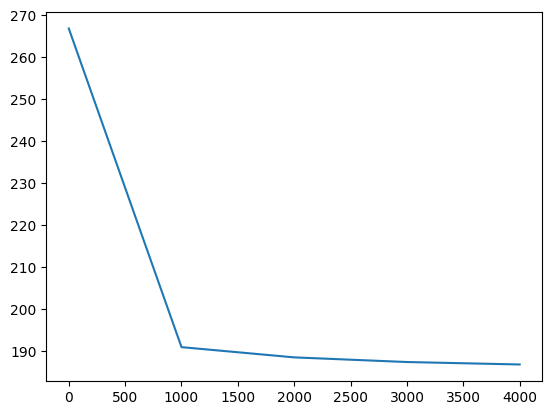

In [11]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 1000
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

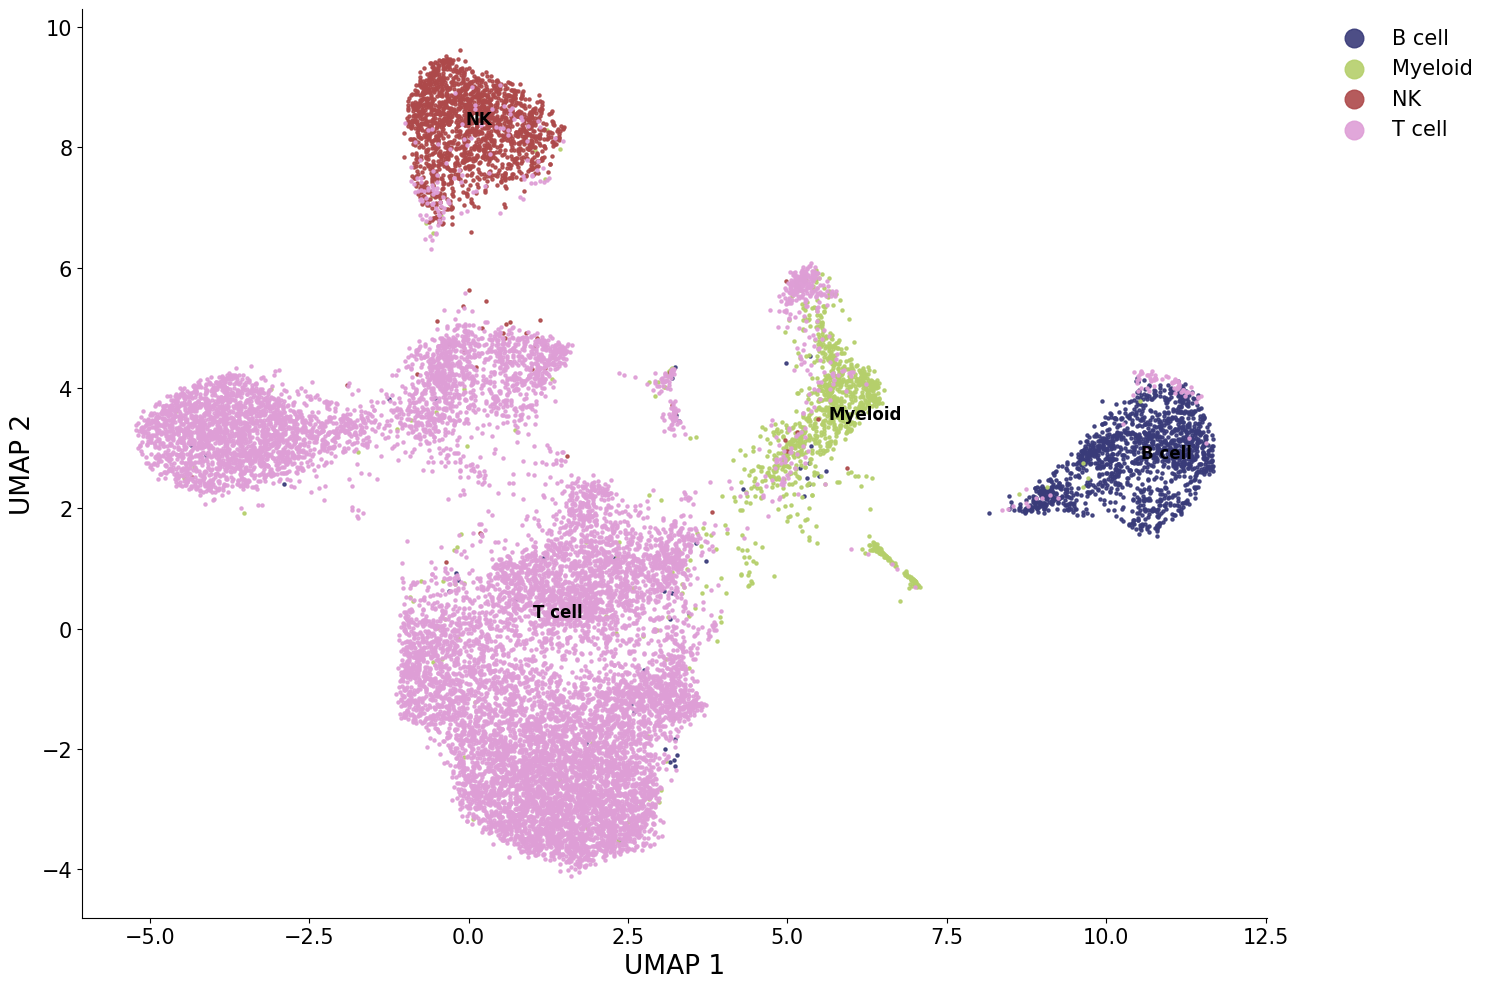

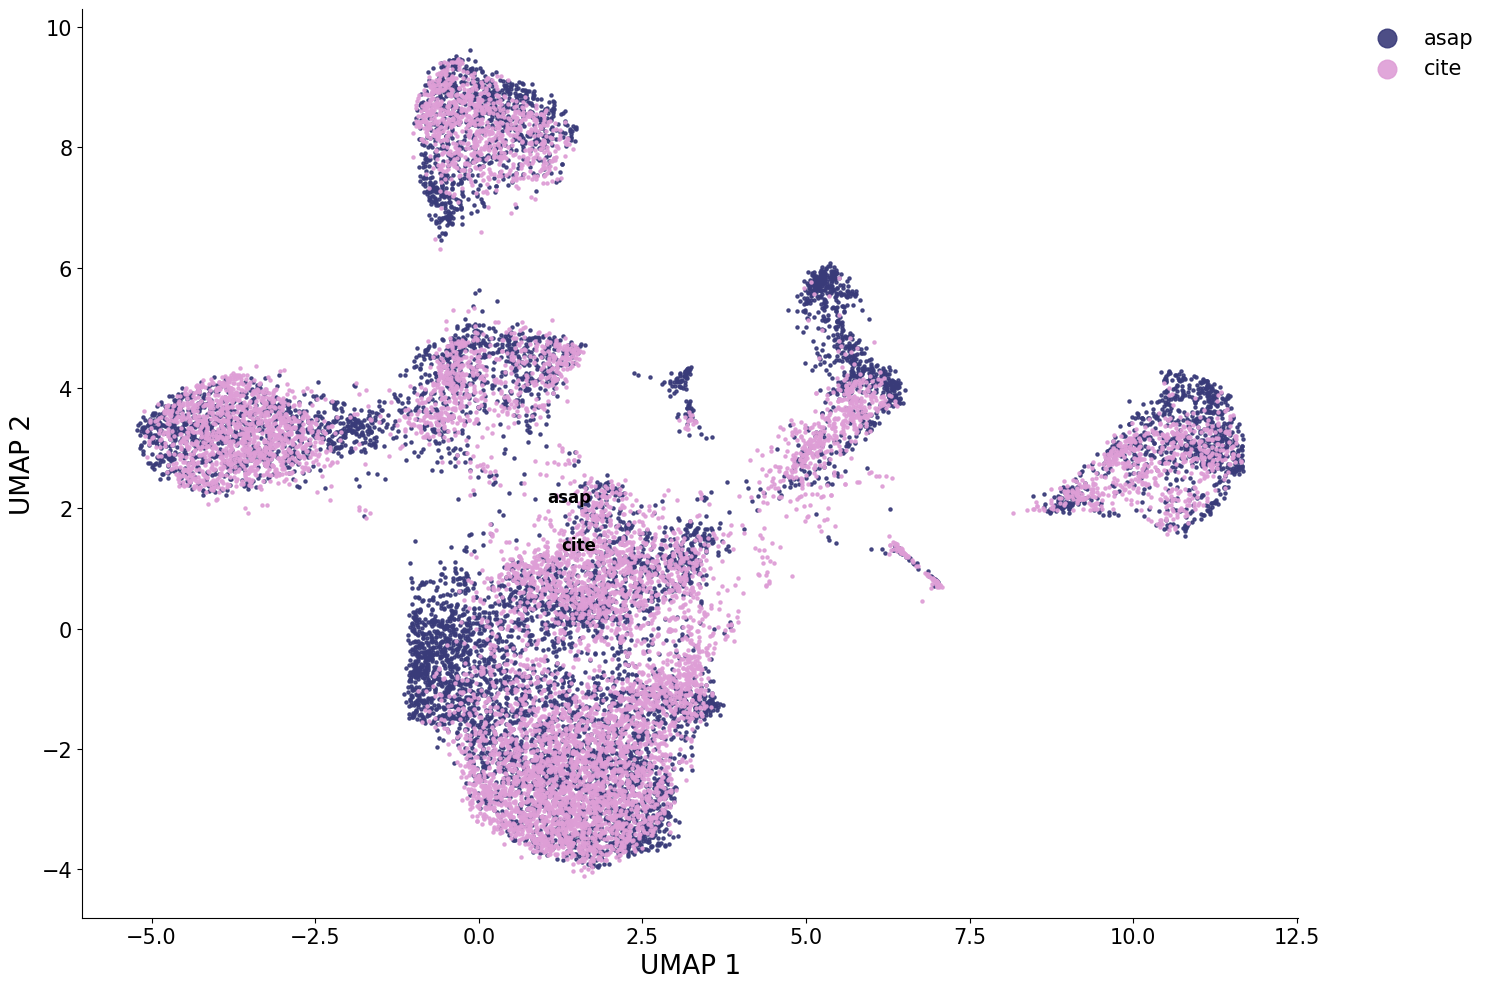

In [12]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

In [13]:
zs = model.extract_cell_factors()

# n_neighbors = 100
# r = None
# resolution = 0.9
# knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# # labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
# x_umap = scmomat.calc_umap_embedding(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(mods),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# scmomat.plot_latent(x_umap, 
#                     annos=np.concatenate(labels),
#                     mode = "joint", save = None,\
#                       figsize = (10,7), axis_label = "UMAP", 
#                     markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# Eval results

In [14]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)

# ad_mosaic.obsm['X_umap'] = x_umap
# ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
#     knn_indices = knn_indices, knn_dists = knn_dists, 
#     n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
# )

# ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [15]:
# import sys
# sys.path.insert(0, '.')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering
from evaluation import eval_bridge_above2

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

### before harmony

In [16]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', 
                batch_keys=['mod', 'batch'], use_lisi=True, use_rep='X_emb', use_neighbors=False,
               use_nmi=False, use_gc=False) 

cell_type_LISI=0.99751
mod_LISI=0.72853
batch_LISI=0.57821


In [16]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=False,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6200394803091204, 0.48438817133768663)

### after harmony

In [17]:
from preprocessing import harmony

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', 
                batch_keys=['mod', 'batch'], use_lisi=True, use_rep='X_emb_harmony', use_neighbors=False,
               use_nmi=False, use_gc=False) 

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).
cell_type_LISI=0.99862
mod_LISI=0.85149
batch_LISI=0.67728


In [18]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony', use_neighbors=False,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6132827811902584, 0.47979634955814665)

# Vis

In [19]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [21]:
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='umap_be')
# ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='umap_af')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

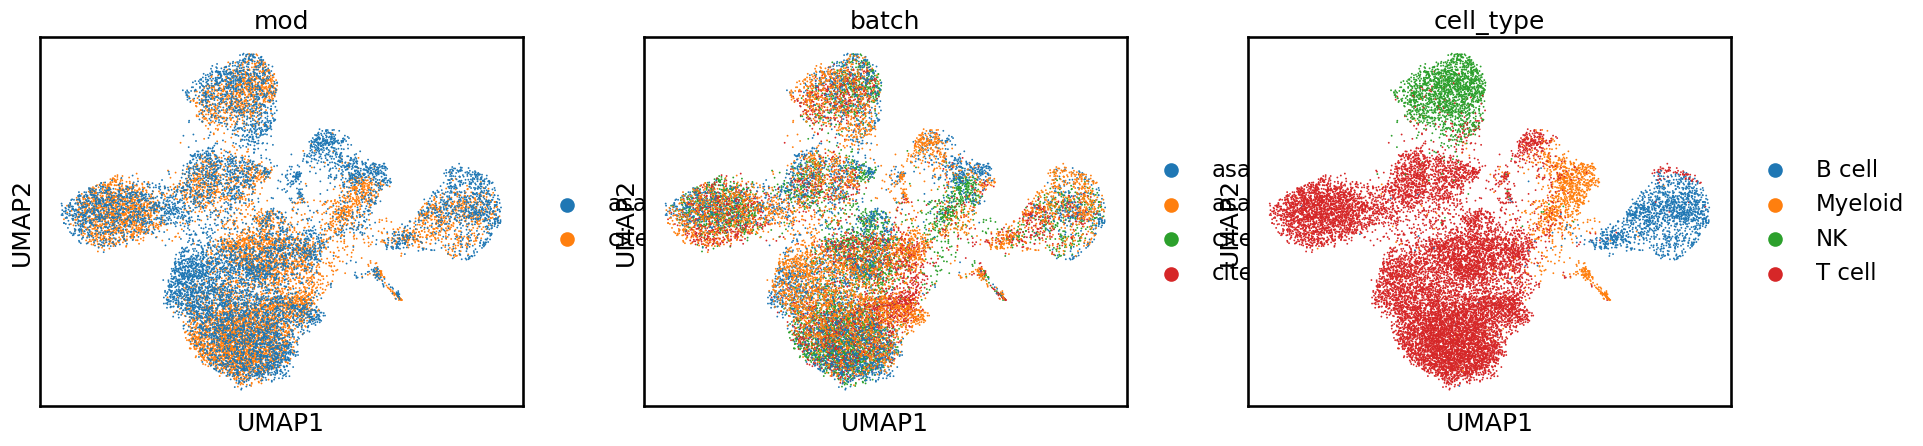

In [22]:
sc.pl.umap(ad_mosaic, color=['mod', 'batch', 'cell_type'])

In [24]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

# save_umap(ad_mosaic, 'umap_be', ['mod', 'batch', 'cell_type'], is_title='', legend_loc=None, 
#           save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
#           prefix_name='scMoMaT_case2_CITE-ASAP')

# save_umap(ad_mosaic, 'umap_af', ['mod', 'batch', 'cell_type'], is_title='', legend_loc=None, 
#           save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
#           prefix_name='scMoMaT-harmony_case2_CITE-ASAP')

In [25]:
np.save(join(umap_save_dir, 'scMoMaT_case2_CITE-ASAP_umap.npy'), ad_mosaic.obsm['umap_be'])
# np.save(join(umap_save_dir, 'scMoMaT-harmony_case2_CITE-ASAP_umap.npy'), ad_mosaic.obsm['umap_af'])

In [1]:
1

1

# Clustering projection

In [26]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'
x_umap = np.load(join(umap_save_dir, 'scMoMaT_case2_CITE-ASAP_umap.npy'))
ad_mosaic = sc.AnnData(x_umap, obsm={"X_emb":x_umap})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)

ad_mosaic.obsm['X_umap'] = x_umap
ad_mosaic.obs_names = np.hstack(barcodes)

In [27]:
ad_cite = ad_mosaic[cite_meta_data.index].copy()

louvain_label = pd.read_csv('/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec4/ACE_louvain.csv', index_col=0)
ad_mosaic.obs['louvain_ace'] = louvain_label.loc[ad_mosaic.obs_names].values.astype("str")

# louvain_label = pd.read_csv('/home/yanxh/gitrepo/multi-omics-matching/Visualization/outputs/CITE-ASAP-refinement/cite_rna_cluster.csv', index_col=0)
# ad_cite.obs['louvain_ace'] = louvain_label.values.ravel().astype('str')

In [28]:
# sc.tl.louvain(ad_mosaic, resolution=1.0)
# sc.pl.umap(ad_mosaic, color=['cell_type', 'louvain'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


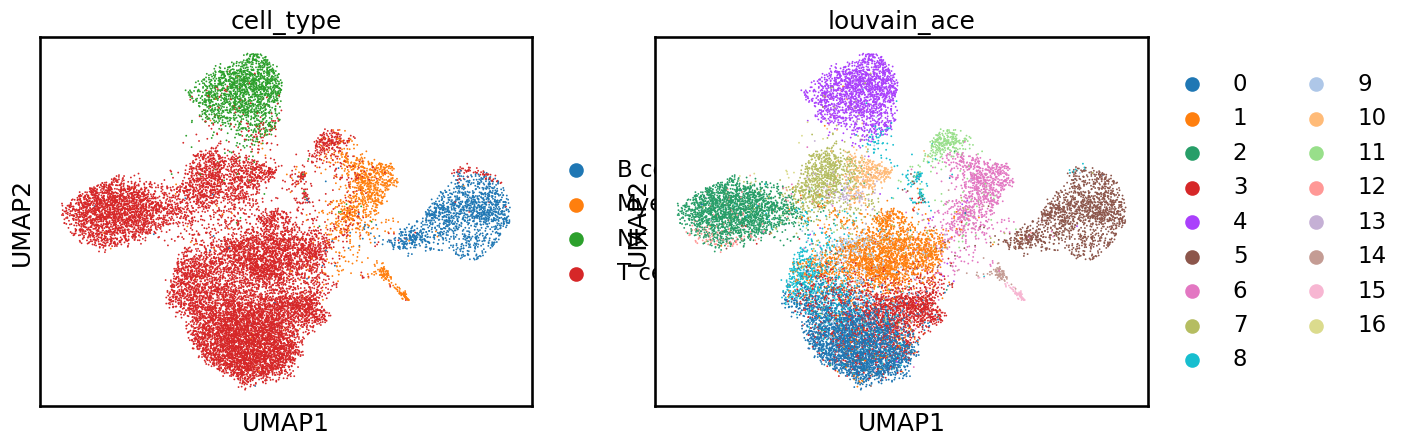

In [29]:
sc.pl.umap(ad_mosaic, color=['cell_type', 'louvain_ace'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


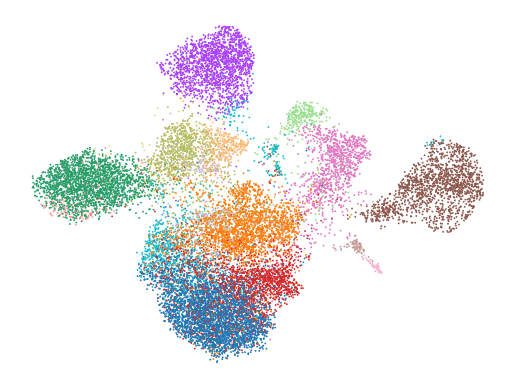

In [30]:
save_umap(ad_mosaic, 'X_umap', ['louvain_ace'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec4', 
          prefix_name='scMoMaT_CITE-ASAP_louvain_from_ACE')